# Argument classifyer

In [1]:
!pip install catboost
!pip install fasttext


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393313 sha256=973f64816dedcc9545a6c1d2beeb132c944996e03aee5be00d8050fbdf6020fc
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [2]:
import logging
import os
import shutil
from google.colab import drive

import re
import os
import random
import string
from collections import Counter
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay,
                             PrecisionRecallDisplay,
                             accuracy_score,
                             mean_absolute_error,
                             mean_squared_error,
                             f1_score,
                             precision_score,
                             recall_score)

import gensim.downloader as api

import fasttext
import fasttext.util

import catboost
from catboost import CatBoostClassifier

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [4]:
logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive'
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'project')
if not os.path.exists(root_data_dir):
    raise RuntimeError('Отсутствует директория с данными')
else:
       logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

INFO:__main__:Инициализировали логгер
INFO:__main__:Подключили диск


Mounted at /content/drive


INFO:__main__:Содержимое директории /content/drive/MyDrive/project: ['circum1001.csv', 'ruwikiruscorpora_tokens_elmo_1024_2019.hdf5', 'circum preds.csv', 'circum.csv', 'circum whole.csv', 'circum noverbs.csv', 'circum roles.csv', 'ruwikiruscorpora_tokens_elmo_1024_2019.zip', 'meta.json', 'vocab.txt', 'model.hdf5', 'options.json', 'ruwikiruscorpora_tokens_elmo_1024_2019', 'wiki_data.txt', 'experiment_df.csv', 'preprocessed_dataset.tsv']


#Business understanding

Данные для проекта берутся из Frame Bank.
https://github.com/olesar/framebank

В них содержатся:
- фразы, полученные в ходе разметки (Phrase)
- глаголы, которые являются "вершиной" фразы (Key Lexemes); при этом важно, что глаголы повторяются в колоках Phrase и Key Lexemes
- классификация выражений по отношению к глаголу: являются ли они Субъектом, Объектом, Периферией и тд. (Type)
- порядок в словосочетании по отношению к глаголу (численное значение)
- грамматическая форма слова (SNOM, SGEN и тд).
- индексы, семантические атрибуты, Rea(?) и начальная форма слова


![image.png](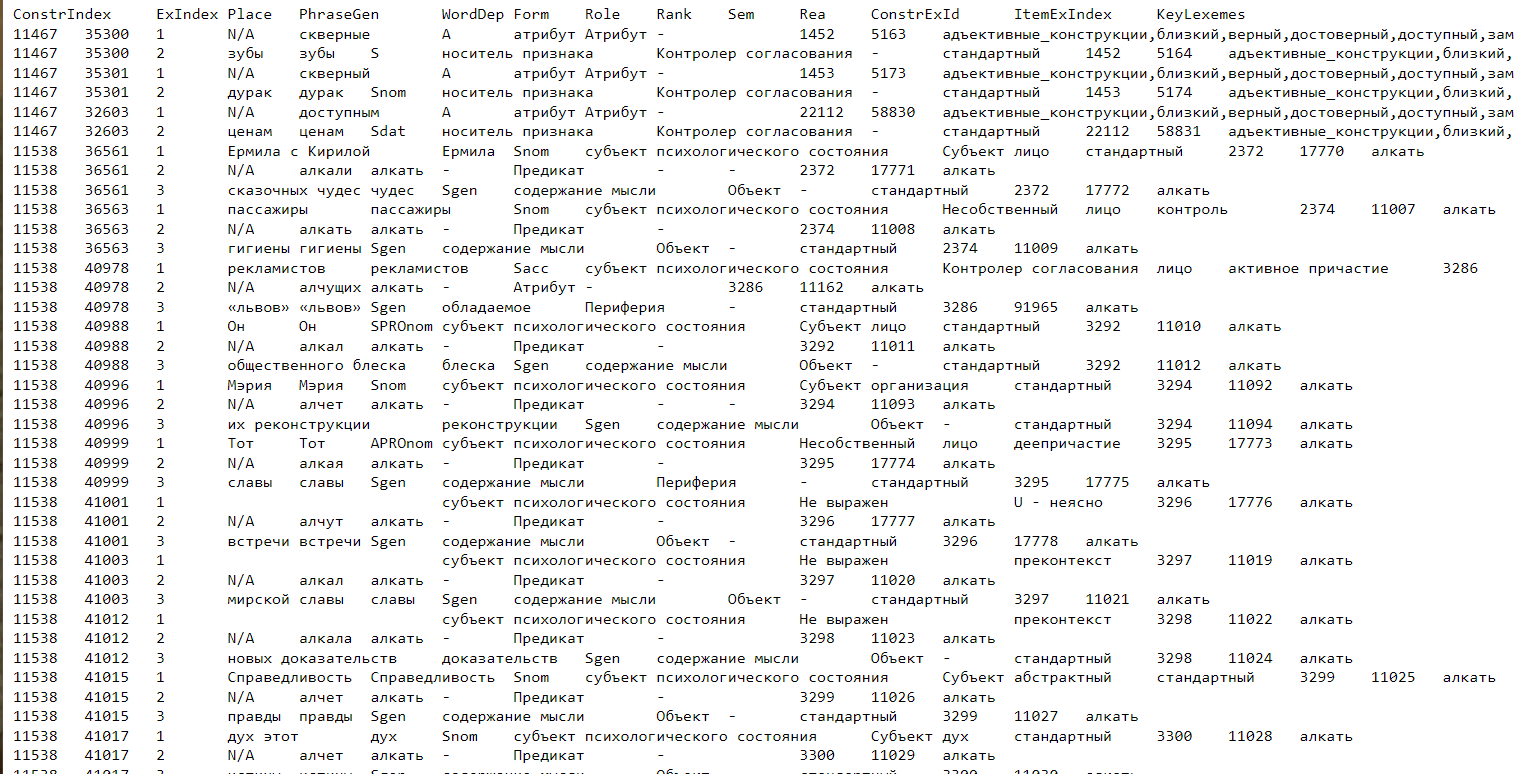)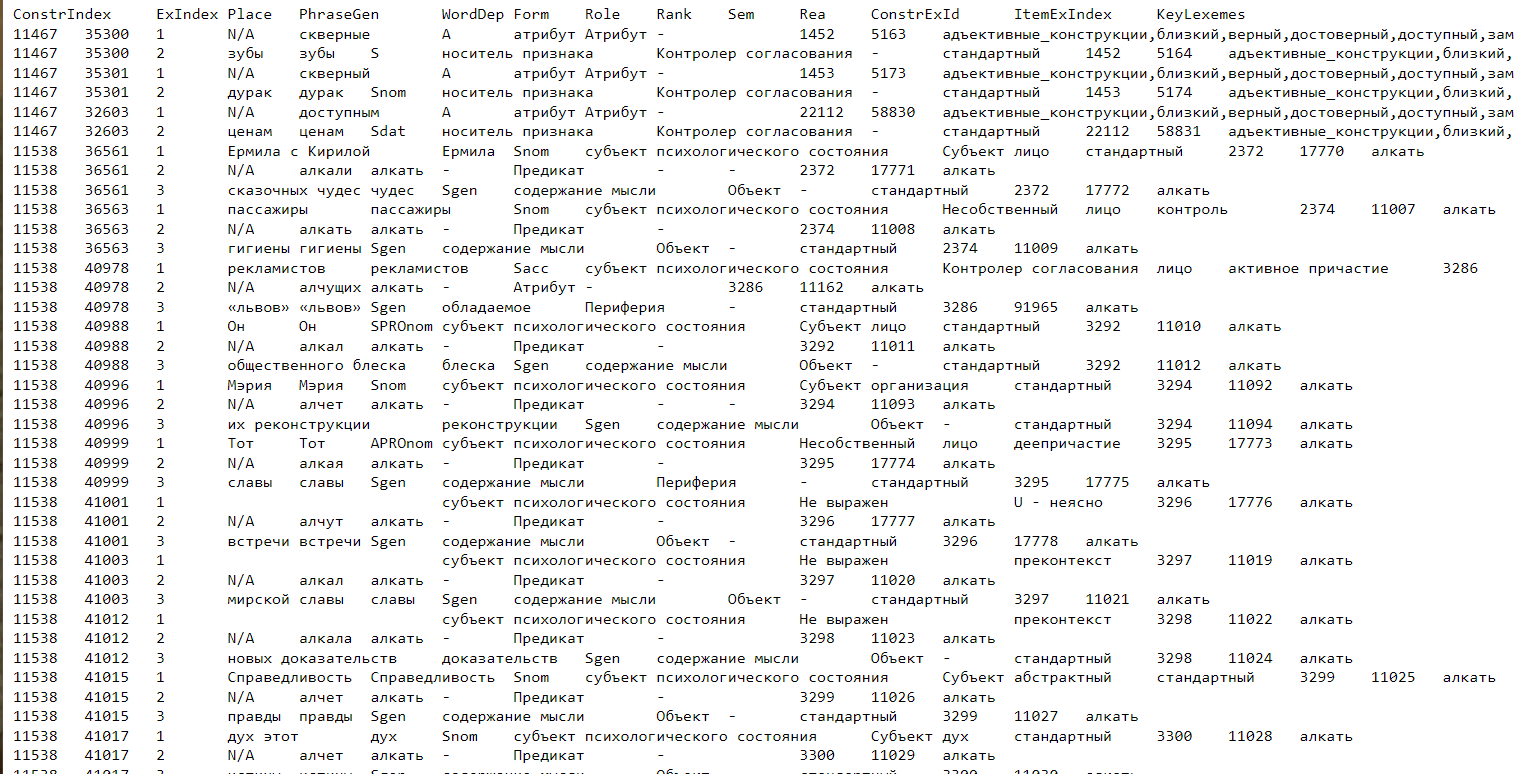

# Data understanding

Наша цель - сделать автономный ресурс, который сможет на основе формы и положения относительно глагола сделать вывод о том, обязательная это зависимость или нет. Поскольку мы не хотим привязываться к разметке фреймбанка, мы сразу удалим внутренние индексы, начальную форму и данные о семантике. При этом мы убрали пересечения глаголов в Phrase и Key Lexemes и заменили Type на численные значения, где 1 - "Субъект", 3 - "Объект" и 2 - все остальные члены предложения. В итоге получается датафрейм experiment_df.

In [5]:
file = os.path.join(root_data_dir, 'experiment_df.csv')
circum_df = pd.read_csv(file, sep=',')
circum_df

,Unnamed: 0,Place,Phrase,Form,Type,KeyLexemes;
0,0,1,Ермила,Snom,1,алкать;
1,2,3,чудес,Sgen,3,алкать;
2,3,1,пассажиры,Snom,1,алкать;
3,5,3,гигиены,Sgen,3,алкать;
4,6,1,рекламистов,Sacc,1,алкать;
...,...,...,...,...,...,...
67296,77593,1,через месяц,через + Sacc,2,явиться;
67297,77594,1,как если бы,CONJ,2,явиться;
67298,77595,1,К сожалению,PARENTH,2,явиться;
67299,77596,1,имея при себе паспорт.,Vger,2,явиться;


Видно, что в Form попали всевозможные предложные конструкции. Это логично, но может быть затруднительно для классификации. Также есть колонка Unnamed:0 с непонятно чем (скорее всего, это сбитая нумерация).

In [6]:
!pip install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.3/352.3 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 70.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=c1db56aa909aa3030bcec1b689e1bb5f7f3133d15e8509163cb2088b5139cbfe
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attemp

In [7]:
import pandas_profiling

circum_df.profile_report()

INFO:visions.backends:Pandas backend loaded 1.5.3
INFO:visions.backends:Numpy backend loaded 1.22.4
INFO:visions.backends:Pyspark backend NOT loaded
INFO:visions.backends:Python backend loaded
<ipython-input-7-713c9c786694>:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
from collections import Counter
Counter(circum_df['Form']).most_common()

[('Snom', 15018),
 ('Sacc', 7740),
 ('ADV', 5302),
 ('SPROnom', 4429),
 ('Sins', 2787),
 ('в + Sloc', 2021),
 ('PART', 1917),
 ('в + Sacc', 1620),
 ('Vinf', 1465),
 ('Sgen', 1451),
 ('SPROacc', 1412),
 ('Sdat', 1221),
 ('на + Sacc', 1207),
 ('V', 1159),
 (nan, 816),
 ('SPROdat', 784),
 ('APROnom', 753),
 ('«CL»', 714),
 ('с + Sins', 706),
 ('что + CL', 614),
 ('от + Sgen', 610),
 ('по + Sdat', 567),
 ('на + Sloc', 542),
 ('к + Sdat', 521),
 ('PRAEDIC', 513),
 ('из + Sgen', 504),
 ('ADVPRO', 471),
 ('CL', 469),
 ('PARENTH', 464),
 ('Vger', 421),
 ('за + Sacc', 327),
 ('Vpraes', 297),
 ('у + Sgen', 256),
 ('SPROins', 252),
 ('о + Sloc', 251),
 ('с + Sgen', 230),
 ('на + Sloc ', 219),
 ('APROacc', 203),
 ('Vfut', 203),
 ('до + Sgen', 202),
 ('NUMnom', 201),
 ('NUMacc', 198),
 ('Abrev', 198),
 ('S', 184),
 ('Ains', 172),
 ('Vimpers', 164),
 ('SPROgen', 163),
 ('за + Sins', 153),
 ('через + Sacc', 137),
 ('Sloc', 136),
 ('для + Sgen', 128),
 ('на + SPROacc', 126),
 ('CONJ', 120),
 ('при + S

In [9]:
Counter(circum_df['KeyLexemes;']).most_common()

[(nan, 811),
 ('обнаруживать;', 444),
 ('информировать;', 423),
 ('явиться;', 393),
 ('появиться;', 384),
 ('потребовать;', 377),
 ('брать;', 346),
 ('возвратить;', 346),
 ('оставаться;', 338),
 ('достигать;', 332),
 ('добиваться;', 330),
 ('зависеть;', 321),
 ('исчезать;', 305),
 ('звучать;', 301),
 ('контролировать;', 293),
 ('вытереть;', 292),
 ('догнать;', 292),
 ('выдвигать;', 284),
 ('превратить;', 270),
 ('внести;', 257),
 ('занести;', 248),
 ('отличаться;', 234),
 ('вырезать;', 231),
 ('метаться;', 231),
 ('нанести;', 230),
 ('заявить;', 228),
 ('превратиться;', 228),
 ('вынести;', 227),
 ('вставать;', 226),
 ('предоставить;', 226),
 ('заменить;', 223),
 ('свести;', 222),
 ('выслушать;', 221),
 ('включать;', 219),
 ('пострадать;', 218),
 ('процитировать;', 217),
 ('претендовать;', 216),
 ('определить;', 212),
 ('становиться;', 212),
 ('войти;', 211),
 ('прятать;', 211),
 ('виднеться;', 210),
 ('выписать;', 209),
 ('выступать;', 209),
 ('укрепить;', 209),
 ('беседовать;', 208),


# Baseline
В качестве бейслайна попробуем обучить логистическую регрессию просто на текстах Phrase.

In [10]:
circum_df.isna().any()

Unnamed: 0     False
Place           True
Phrase          True
Form            True
Type            True
KeyLexemes;     True
dtype: bool

In [11]:
print(circum_df.shape)
circum_df = circum_df.dropna()
circum_df.shape

(67301, 6)


(66447, 6)

In [12]:
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

In [13]:
# создаём функцию для векторизации фасттекстом
def text_to_vector(text):
    vector = np.zeros(fasttext.get_dimension())
    count = 0
    for word in text.split():
        if word in fasttext.words:
            vector += fasttext.get_word_vector(word)
            count += 1
    if count != 0:
        vector /= count
    return vector

In [14]:
import fasttext
import fasttext.util
import numpy as np
import pandas as pd


def text_to_vector(text):
    vector = np.zeros(ft.get_word_vector("word").shape[0])
    count = 0
    for word in text.split():
        if word in ft:
            vector += ft.get_word_vector(word)
            count += 1
    if count != 0:
        vector /= count
    return vector

In [15]:
circum_df.shape

(66447, 6)

In [16]:
max_columns = 10
phrase_sequence = ['Ph{}'.format(i+1) for i in range(max_columns)]

In [18]:
phrase_vectors = circum_df['Phrase'].apply(lambda x: text_to_vector(x)).tolist()
phrase_vectors_df = pd.DataFrame(phrase_vectors)
phrase_vectors_df = phrase_vectors_df.iloc[:, :max_columns]
phrase_vectors_df.columns = phrase_sequence
phrase_vectors_df.head()

,Ph1,Ph2,Ph3,Ph4,Ph5,Ph6,Ph7,Ph8,Ph9,Ph10
0,-0.072813,-0.037378,0.037228,-0.021215,-0.007029,0.036577,-0.049445,-0.058492,-0.032258,0.030762
1,-0.078081,0.028169,-0.090320,0.059401,-0.122303,0.045220,-0.118337,-0.051898,-0.104505,0.048278
2,0.060996,-0.043253,0.000424,-0.010135,0.012541,-0.028278,0.061805,0.049421,-0.039804,0.010357
3,0.025874,-0.031918,-0.032221,0.003710,-0.033849,-0.035168,0.094363,-0.006710,-0.029380,0.052780
4,0.004496,-0.023495,-0.011903,0.077535,-0.059768,-0.046063,0.052028,0.039245,0.000861,0.010147


In [19]:
phrase_vectors_df

,Ph1,Ph2,Ph3,Ph4,Ph5,Ph6,Ph7,Ph8,Ph9,Ph10
0,-0.072813,-0.037378,0.037228,-0.021215,-0.007029,0.036577,-0.049445,-0.058492,-0.032258,0.030762
1,-0.078081,0.028169,-0.090320,0.059401,-0.122303,0.045220,-0.118337,-0.051898,-0.104505,0.048278
2,0.060996,-0.043253,0.000424,-0.010135,0.012541,-0.028278,0.061805,0.049421,-0.039804,0.010357
3,0.025874,-0.031918,-0.032221,0.003710,-0.033849,-0.035168,0.094363,-0.006710,-0.029380,0.052780
4,0.004496,-0.023495,-0.011903,0.077535,-0.059768,-0.046063,0.052028,0.039245,0.000861,0.010147
...,...,...,...,...,...,...,...,...,...,...
66442,0.029733,-0.065861,-0.022905,0.029429,-0.000012,-0.017961,0.043725,-0.017786,0.050797,-0.045850
66443,0.055818,-0.064005,0.077752,0.011541,0.028862,-0.000412,-0.056460,-0.018821,-0.092030,0.038256
66444,-0.007286,-0.014829,0.044437,-0.003970,-0.023374,0.157136,-0.054846,0.054375,-0.017753,-0.138726
66445,0.053434,-0.055484,0.027089,0.073556,0.028695,0.021322,-0.068467,-0.012046,0.002809,-0.034525


In [20]:
target = circum_df['Type'].values
target.shape

(66447,)

In [21]:
phrase_vectors_df.columns =  phrase_vectors_df.columns.astype(str)

sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(
    sc.fit_transform(phrase_vectors_df), target, test_size=0.3, random_state=RANDOM_SEED)

In [22]:
X_train.shape

(46512, 10)

In [23]:
y_train.shape

(46512,)

In [24]:
regressor = LogisticRegression()
regressor.fit(X_train, y_train)

LogisticRegression()

In [25]:
y_preds = regressor.predict(X_test)
y_preds

array(['2', '2', '2', ..., '2', '1', '2'], dtype=object)

In [26]:
print(f"LogisticRegression Accuracy: {accuracy_score(y_test, y_preds)}")
print(f"LogisticRegression Precision: {precision_score(y_test, y_preds, average='weighted')}")
print(f"LogisticRegression Recall: {recall_score(y_test, y_preds, average='weighted')}")
print(f"LogisticRegression F1: {f1_score(y_test, y_preds, average='weighted')}")

LogisticRegression Accuracy: 0.5525959367945824
LogisticRegression Precision: 0.5032518224708948


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression Recall: 0.5525959367945824
LogisticRegression F1: 0.4712212388571537


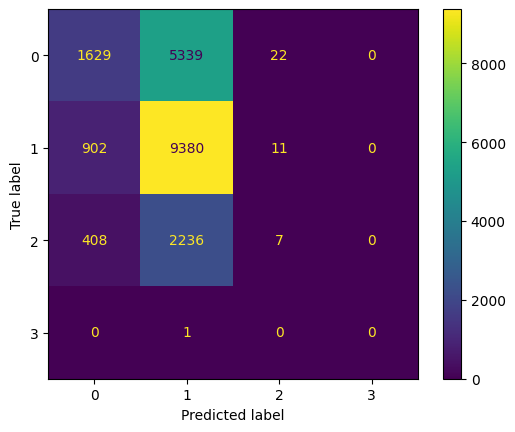

In [27]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Modelling
### Cleaning text columns

Поскольку предлоги создают очень много типов формы, мы заменим конструкции с ними на новый тег "CONSTR"

In [28]:
def passes_regex(my_str):
    return bool(re.match('^[A-Za-z]+$', str(my_str)))


circum_df['Form'] = circum_df['Form'].apply(lambda x: x if passes_regex(x) else 'CONSTR')
circum_df.tail()

<ipython-input-28-2400de9c3218>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circum_df['Form'] = circum_df['Form'].apply(lambda x: x if passes_regex(x) else 'CONSTR')


,Unnamed: 0,Place,Phrase,Form,Type,KeyLexemes;
67296,77593,1,через месяц,CONSTR,2,явиться;
67297,77594,1,как если бы,CONJ,2,явиться;
67298,77595,1,К сожалению,PARENTH,2,явиться;
67299,77596,1,имея при себе паспорт.,Vger,2,явиться;
67300,77597,1,Предлагается,Vpraes,2,явиться;


Заем уберём самые редкие из консрукций (порог - 100 вхождений)

In [29]:
tag_counts = circum_df['Form'].value_counts()
tags_to_drop = tag_counts[tag_counts < 100].index
circum_df = circum_df[~circum_df['Form'].isin(tags_to_drop)]
circum_df['Form'].value_counts()

CONSTR     15546
Snom       14999
Sacc        7735
ADV         5301
SPROnom     4429
Sins        2787
PART        1916
Vinf        1465
Sgen        1451
SPROacc     1412
Sdat        1218
V           1159
SPROdat      782
APROnom      753
PRAEDIC      513
ADVPRO       471
CL           469
PARENTH      464
Vger         421
Vpraes       297
SPROins      252
APROacc      203
Vfut         203
NUMnom       201
NUMacc       198
Abrev        198
S            184
Ains         172
Vimpers      164
SPROgen      163
Sloc         136
CONJ         120
Name: Form, dtype: int64

In [30]:
a = Counter(circum_df['Form'])

n = 0
for i in a.keys():
    if re.match('^[A-Za-z]+$', str(i)):
        n += 1

n

32

In [31]:
circum_df.isna().any()

Unnamed: 0     False
Place          False
Phrase         False
Form           False
Type           False
KeyLexemes;    False
dtype: bool

In [32]:
print(circum_df.shape)
circum_df = circum_df.dropna()
circum_df.shape

(65782, 6)


(65782, 6)

In [33]:
non_numeric_tags = circum_df[circum_df['Type'].str.contains('[^0-9]+', regex=True)]['Type'].unique()
circum_df = circum_df[~circum_df['Type'].isin(non_numeric_tags)]

In [34]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


circum_df['KeyLexemes;'] = circum_df['KeyLexemes;'].apply(remove_punctuation)
circum_df

,Unnamed: 0,Place,Phrase,Form,Type,KeyLexemes;
0,0,1,Ермила,Snom,1,алкать
1,2,3,чудес,Sgen,3,алкать
2,3,1,пассажиры,Snom,1,алкать
3,5,3,гигиены,Sgen,3,алкать
4,6,1,рекламистов,Sacc,1,алкать
...,...,...,...,...,...,...
67296,77593,1,через месяц,CONSTR,2,явиться
67297,77594,1,как если бы,CONJ,2,явиться
67298,77595,1,К сожалению,PARENTH,2,явиться
67299,77596,1,имея при себе паспорт.,Vger,2,явиться


In [35]:
circum_df = circum_df.reset_index(drop=True)

### One-hot encoding

#### Form

In [36]:
data = np.array(circum_df['Form']).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
one_hot_form = encoder.fit_transform(data)
one_hot_form

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [37]:
ohe_df2 = pd.DataFrame(one_hot_form, columns=encoder.get_feature_names_out())
circum_df = pd.concat([circum_df, ohe_df2], axis=1)
circum_df

,Unnamed: 0,Place,Phrase,Form,Type,KeyLexemes;,x0_ADV,x0_ADVPRO,x0_APROacc,x0_APROnom,...,x0_Sgen,x0_Sins,x0_Sloc,x0_Snom,x0_V,x0_Vfut,x0_Vger,x0_Vimpers,x0_Vinf,x0_Vpraes
0,0,1,Ермила,Snom,1,алкать,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,3,чудес,Sgen,3,алкать,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,пассажиры,Snom,1,алкать,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,3,гигиены,Sgen,3,алкать,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,1,рекламистов,Sacc,1,алкать,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65776,77593,1,через месяц,CONSTR,2,явиться,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65777,77594,1,как если бы,CONJ,2,явиться,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65778,77595,1,К сожалению,PARENTH,2,явиться,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65779,77596,1,имея при себе паспорт.,Vger,2,явиться,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [38]:
circum_df.isna().any()

Unnamed: 0     False
Place          False
Phrase         False
Form           False
Type           False
KeyLexemes;    False
x0_ADV         False
x0_ADVPRO      False
x0_APROacc     False
x0_APROnom     False
x0_Abrev       False
x0_Ains        False
x0_CL          False
x0_CONJ        False
x0_CONSTR      False
x0_NUMacc      False
x0_NUMnom      False
x0_PARENTH     False
x0_PART        False
x0_PRAEDIC     False
x0_S           False
x0_SPROacc     False
x0_SPROdat     False
x0_SPROgen     False
x0_SPROins     False
x0_SPROnom     False
x0_Sacc        False
x0_Sdat        False
x0_Sgen        False
x0_Sins        False
x0_Sloc        False
x0_Snom        False
x0_V           False
x0_Vfut        False
x0_Vger        False
x0_Vimpers     False
x0_Vinf        False
x0_Vpraes      False
dtype: bool

### FastText vectorization

In [39]:
max_columns = 10
phrase_sequence = ['KL{}'.format(i+1) for i in range(max_columns)]

In [40]:
vectors = circum_df['KeyLexemes;'].apply(lambda x: text_to_vector(x)).tolist()
vectors_df = pd.DataFrame(vectors)
vectors_df = vectors_df.iloc[:, :max_columns]
vectors_df.columns = phrase_sequence
vectors_df.head()

,KL1,KL2,KL3,KL4,KL5,KL6,KL7,KL8,KL9,KL10
0,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562
1,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562
2,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562
3,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562
4,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562


In [88]:
vectors_df

,KL1,KL2,KL3,KL4,KL5,KL6,KL7,KL8,KL9,KL10
0,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
1,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
2,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
3,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
4,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
...,...,...,...,...,...,...,...,...,...,...
65776,0.037347,-0.000233,0.014994,-0.003786,0.065791,0.027297,-0.016023,-0.022759,0.028499,-0.012825
65777,0.037347,-0.000233,0.014994,-0.003786,0.065791,0.027297,-0.016023,-0.022759,0.028499,-0.012825
65778,0.037347,-0.000233,0.014994,-0.003786,0.065791,0.027297,-0.016023,-0.022759,0.028499,-0.012825
65779,0.037347,-0.000233,0.014994,-0.003786,0.065791,0.027297,-0.016023,-0.022759,0.028499,-0.012825


In [41]:
keylex_added = pd.concat([circum_df, vectors_df], axis=1)
keylex_added.head()

,Unnamed: 0,Place,Phrase,Form,Type,KeyLexemes;,x0_ADV,x0_ADVPRO,x0_APROacc,x0_APROnom,...,KL1,KL2,KL3,KL4,KL5,KL6,KL7,KL8,KL9,KL10
0,0,1,Ермила,Snom,1,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562
1,2,3,чудес,Sgen,3,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562
2,3,1,пассажиры,Snom,1,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562
3,5,3,гигиены,Sgen,3,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562
4,6,1,рекламистов,Sacc,1,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.03014,0.00317,-0.023023,-0.039304,0.047461,0.01723,-0.003946,-0.069562


In [89]:
keylex_added

,Unnamed: 0,Place,Phrase,Form,Type,KeyLexemes;,x0_ADV,x0_ADVPRO,x0_APROacc,x0_APROnom,...,KL1,KL2,KL3,KL4,KL5,KL6,KL7,KL8,KL9,KL10
0,0,1,Ермила,Snom,1,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
1,2,3,чудес,Sgen,3,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
2,3,1,пассажиры,Snom,1,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
3,5,3,гигиены,Sgen,3,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
4,6,1,рекламистов,Sacc,1,алкать,0.0,0.0,0.0,0.0,...,0.065692,0.013423,-0.030140,0.003170,-0.023023,-0.039304,0.047461,0.017230,-0.003946,-0.069562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65776,77593,1,через месяц,CONSTR,2,явиться,0.0,0.0,0.0,0.0,...,0.037347,-0.000233,0.014994,-0.003786,0.065791,0.027297,-0.016023,-0.022759,0.028499,-0.012825
65777,77594,1,как если бы,CONJ,2,явиться,0.0,0.0,0.0,0.0,...,0.037347,-0.000233,0.014994,-0.003786,0.065791,0.027297,-0.016023,-0.022759,0.028499,-0.012825
65778,77595,1,К сожалению,PARENTH,2,явиться,0.0,0.0,0.0,0.0,...,0.037347,-0.000233,0.014994,-0.003786,0.065791,0.027297,-0.016023,-0.022759,0.028499,-0.012825
65779,77596,1,имея при себе паспорт.,Vger,2,явиться,0.0,0.0,0.0,0.0,...,0.037347,-0.000233,0.014994,-0.003786,0.065791,0.027297,-0.016023,-0.022759,0.028499,-0.012825


In [50]:
max_columns = 10
sequence = ['Ph{}'.format(i+1) for i in range(max_columns)]

In [51]:
phrase_vectors = circum_df['Phrase'].apply(lambda x: text_to_vector(x)).tolist()
phrase_vectors_df = pd.DataFrame(phrase_vectors)
phrase_vectors_df = phrase_vectors_df.iloc[:, :max_columns]
phrase_vectors_df.columns = sequence
phrase_vectors_df.head()

,Ph1,Ph2,Ph3,Ph4,Ph5,Ph6,Ph7,Ph8,Ph9,Ph10
0,-0.072813,-0.037378,0.037228,-0.021215,-0.007029,0.036577,-0.049445,-0.058492,-0.032258,0.030762
1,-0.078081,0.028169,-0.090320,0.059401,-0.122303,0.045220,-0.118337,-0.051898,-0.104505,0.048278
2,0.060996,-0.043253,0.000424,-0.010135,0.012541,-0.028278,0.061805,0.049421,-0.039804,0.010357
3,0.025874,-0.031918,-0.032221,0.003710,-0.033849,-0.035168,0.094363,-0.006710,-0.029380,0.052780
4,0.004496,-0.023495,-0.011903,0.077535,-0.059768,-0.046063,0.052028,0.039245,0.000861,0.010147


In [110]:
phrase_vectors_df

,Ph1,Ph2,Ph3,Ph4,Ph5,Ph6,Ph7,Ph8,Ph9,Ph10
0,-0.072813,-0.037378,0.037228,-0.021215,-0.007029,0.036577,-0.049445,-0.058492,-0.032258,0.030762
1,-0.078081,0.028169,-0.090320,0.059401,-0.122303,0.045220,-0.118337,-0.051898,-0.104505,0.048278
2,0.060996,-0.043253,0.000424,-0.010135,0.012541,-0.028278,0.061805,0.049421,-0.039804,0.010357
3,0.025874,-0.031918,-0.032221,0.003710,-0.033849,-0.035168,0.094363,-0.006710,-0.029380,0.052780
4,0.004496,-0.023495,-0.011903,0.077535,-0.059768,-0.046063,0.052028,0.039245,0.000861,0.010147
...,...,...,...,...,...,...,...,...,...,...
65776,0.029733,-0.065861,-0.022905,0.029429,-0.000012,-0.017961,0.043725,-0.017786,0.050797,-0.045850
65777,0.055818,-0.064005,0.077752,0.011541,0.028862,-0.000412,-0.056460,-0.018821,-0.092030,0.038256
65778,-0.007286,-0.014829,0.044437,-0.003970,-0.023374,0.157136,-0.054846,0.054375,-0.017753,-0.138726
65779,0.053434,-0.055484,0.027089,0.073556,0.028695,0.021322,-0.068467,-0.012046,0.002809,-0.034525


In [111]:
result_df = pd.concat([keylex_added, phrase_vectors_df], axis=1)
result_df.head()

,Unnamed: 0,Place,Phrase,Form,Type,KeyLexemes;,x0_ADV,x0_ADVPRO,x0_APROacc,x0_APROnom,...,Ph1,Ph2,Ph3,Ph4,Ph5,Ph6,Ph7,Ph8,Ph9,Ph10
0,0,1,Ермила,Snom,1,алкать,0.0,0.0,0.0,0.0,...,-0.072813,-0.037378,0.037228,-0.021215,-0.007029,0.036577,-0.049445,-0.058492,-0.032258,0.030762
1,2,3,чудес,Sgen,3,алкать,0.0,0.0,0.0,0.0,...,-0.078081,0.028169,-0.090320,0.059401,-0.122303,0.045220,-0.118337,-0.051898,-0.104505,0.048278
2,3,1,пассажиры,Snom,1,алкать,0.0,0.0,0.0,0.0,...,0.060996,-0.043253,0.000424,-0.010135,0.012541,-0.028278,0.061805,0.049421,-0.039804,0.010357
3,5,3,гигиены,Sgen,3,алкать,0.0,0.0,0.0,0.0,...,0.025874,-0.031918,-0.032221,0.003710,-0.033849,-0.035168,0.094363,-0.006710,-0.029380,0.052780
4,6,1,рекламистов,Sacc,1,алкать,0.0,0.0,0.0,0.0,...,0.004496,-0.023495,-0.011903,0.077535,-0.059768,-0.046063,0.052028,0.039245,0.000861,0.010147


In [112]:
target = result_df['Type'].values
target.shape

(65781,)

In [113]:
result_df.drop(columns=['Phrase', 'Form', 'Type', 'KeyLexemes;'], inplace=True)
result_df.head()

,Unnamed: 0,Place,x0_ADV,x0_ADVPRO,x0_APROacc,x0_APROnom,x0_Abrev,x0_Ains,x0_CL,x0_CONJ,...,Ph1,Ph2,Ph3,Ph4,Ph5,Ph6,Ph7,Ph8,Ph9,Ph10
0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.072813,-0.037378,0.037228,-0.021215,-0.007029,0.036577,-0.049445,-0.058492,-0.032258,0.030762
1,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.078081,0.028169,-0.090320,0.059401,-0.122303,0.045220,-0.118337,-0.051898,-0.104505,0.048278
2,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.060996,-0.043253,0.000424,-0.010135,0.012541,-0.028278,0.061805,0.049421,-0.039804,0.010357
3,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025874,-0.031918,-0.032221,0.003710,-0.033849,-0.035168,0.094363,-0.006710,-0.029380,0.052780
4,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004496,-0.023495,-0.011903,0.077535,-0.059768,-0.046063,0.052028,0.039245,0.000861,0.010147


In [114]:
result_df

,Unnamed: 0,Place,x0_ADV,x0_ADVPRO,x0_APROacc,x0_APROnom,x0_Abrev,x0_Ains,x0_CL,x0_CONJ,...,Ph1,Ph2,Ph3,Ph4,Ph5,Ph6,Ph7,Ph8,Ph9,Ph10
0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.072813,-0.037378,0.037228,-0.021215,-0.007029,0.036577,-0.049445,-0.058492,-0.032258,0.030762
1,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.078081,0.028169,-0.090320,0.059401,-0.122303,0.045220,-0.118337,-0.051898,-0.104505,0.048278
2,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.060996,-0.043253,0.000424,-0.010135,0.012541,-0.028278,0.061805,0.049421,-0.039804,0.010357
3,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025874,-0.031918,-0.032221,0.003710,-0.033849,-0.035168,0.094363,-0.006710,-0.029380,0.052780
4,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004496,-0.023495,-0.011903,0.077535,-0.059768,-0.046063,0.052028,0.039245,0.000861,0.010147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65776,77593,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.029733,-0.065861,-0.022905,0.029429,-0.000012,-0.017961,0.043725,-0.017786,0.050797,-0.045850
65777,77594,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.055818,-0.064005,0.077752,0.011541,0.028862,-0.000412,-0.056460,-0.018821,-0.092030,0.038256
65778,77595,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.007286,-0.014829,0.044437,-0.003970,-0.023374,0.157136,-0.054846,0.054375,-0.017753,-0.138726
65779,77596,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.053434,-0.055484,0.027089,0.073556,0.028695,0.021322,-0.068467,-0.012046,0.002809,-0.034525


In [115]:
result_df.isna().any()

Unnamed: 0    False
Place         False
x0_ADV        False
x0_ADVPRO     False
x0_APROacc    False
x0_APROnom    False
x0_Abrev      False
x0_Ains       False
x0_CL         False
x0_CONJ       False
x0_CONSTR     False
x0_NUMacc     False
x0_NUMnom     False
x0_PARENTH    False
x0_PART       False
x0_PRAEDIC    False
x0_S          False
x0_SPROacc    False
x0_SPROdat    False
x0_SPROgen    False
x0_SPROins    False
x0_SPROnom    False
x0_Sacc       False
x0_Sdat       False
x0_Sgen       False
x0_Sins       False
x0_Sloc       False
x0_Snom       False
x0_V          False
x0_Vfut       False
x0_Vger       False
x0_Vimpers    False
x0_Vinf       False
x0_Vpraes     False
KL1           False
KL2           False
KL3           False
KL4           False
KL5           False
KL6           False
KL7           False
KL8           False
KL9           False
KL10          False
Ph1           False
Ph2           False
Ph3           False
Ph4           False
Ph5           False
Ph6           False


In [116]:
result_df.to_csv('preprocessed_dataset.tsv', sep='\t', index=False)

In [117]:
result_df = pd.read_csv('preprocessed_dataset.tsv', sep='\t')

In [74]:
#file1 = os.path.join(root_data_dir, 'preprocessed_dataset.tsv')
#result_df = pd.read_csv(file1, sep='\t')

In [118]:
feat_cols = ['Place'] + phrase_sequence + sequence + ['x0_CONSTR', 'x0_Snom', 'x0_Sacc', 'x0_ADV', 'x0_SPROnom', 'x0_Sins', 'x0_PART','x0_Vinf', 'x0_Sgen', 'x0_SPROacc', 'x0_Sdat', 'x0_V', 'x0_SPROdat', 'x0_APROnom', 'x0_PRAEDIC', 'x0_ADVPRO', 'x0_CL', 'x0_PARENTH', 'x0_Vger', 'x0_Vpraes', 'x0_SPROins', 'x0_APROacc', 'x0_Vfut', 'x0_NUMnom', 'x0_NUMacc', 'x0_Abrev', 'x0_S', 'x0_Ains', 'x0_Vimpers', 'x0_SPROgen', 'x0_Sloc', 'x0_CONJ']
features = result_df[feat_cols]

In [119]:
vector_cols = sequence + phrase_sequence
vector_data = features[vector_cols].values

In [120]:
one_hot_cols = [col for col in features.columns if col not in vector_cols and col != 'Place' and col != 'Unnamed: 0']
one_hot_data = features[one_hot_cols].values

In [121]:
integer_data = features['Place'].values.reshape(-1, 1)

In [122]:
column_names = ['Place'] + vector_cols + one_hot_cols

In [123]:
data = pd.concat([pd.DataFrame(integer_data, columns=['Place']),
                  pd.DataFrame(vector_data, columns=vector_cols),
                  pd.DataFrame(one_hot_data)], axis=1)

In [124]:
data.shape

(65781, 53)

In [125]:
data.isna().any()

Place    False
Ph1      False
Ph2      False
Ph3      False
Ph4      False
Ph5      False
Ph6      False
Ph7      False
Ph8      False
Ph9      False
Ph10     False
KL1      False
KL2      False
KL3      False
KL4      False
KL5      False
KL6      False
KL7      False
KL8      False
KL9      False
KL10     False
0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
30       False
31       False
dtype: bool

In [126]:
data.columns = data.columns.astype(str)

sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(data), target, test_size=0.3, random_state=RANDOM_SEED)

In [127]:
X_train.shape

(46046, 53)

In [128]:
y_train.shape

(46046,)

## Classification
### Logistic Regression

In [129]:
regressor = LogisticRegression()
regressor.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [130]:
y_preds = regressor.predict(X_test)
y_preds

array(['3', '1', '2', ..., '3', '1', '3'], dtype=object)

In [131]:
print(f"LogisticRegression Accuracy: {accuracy_score(y_test, y_preds)}")
print(f"LogisticRegression Precision: {precision_score(y_test, y_preds, average='weighted')}")
print(f"LogisticRegression Recall: {recall_score(y_test, y_preds, average='weighted')}")
print(f"LogisticRegression F1: {f1_score(y_test, y_preds, average='weighted')}")

LogisticRegression Accuracy: 0.9568786420065872
LogisticRegression Precision: 0.9570958161926355
LogisticRegression Recall: 0.9568786420065872
LogisticRegression F1: 0.9567748833457557


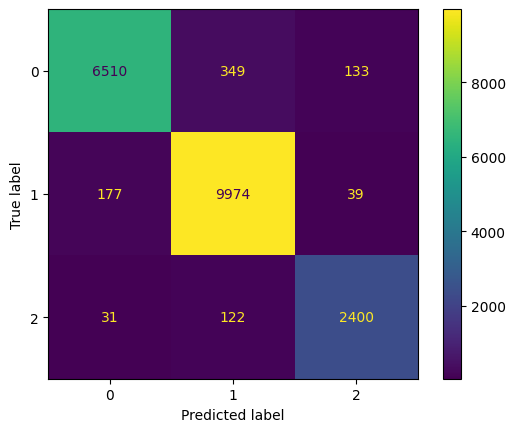

In [132]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### CatBoost

In [133]:
clf = CatBoostClassifier(verbose=0)

In [134]:
clf.fit(X_train, y_train)

In [135]:
y_pred = clf.predict(X_test)

In [136]:
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"CatBoost Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"CatBoost Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"CatBoost F1: {f1_score(y_test, y_pred, average='weighted')}")

CatBoost Accuracy: 0.9705599189257664
CatBoost Precision: 0.9709343945697786
CatBoost Recall: 0.9705599189257664
CatBoost F1: 0.9705255439857283


### Random Forest

In [137]:
classifier = RandomForestClassifier(n_estimators=300)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [138]:
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Random Forest Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Random Forest Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"Random Forest F1: {f1_score(y_test, y_pred, average='weighted')}")

Random Forest Accuracy: 0.9679250063339245
Random Forest Precision: 0.9682914384895307
Random Forest Recall: 0.9679250063339245
Random Forest F1: 0.9678594459566001
